## 0. Импорт библиотек, определение функций

In [1]:
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import numpy as np
from scipy.stats import kstest, spearmanr, mannwhitneyu, levene, kruskal

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler,  PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
import statsmodels.api as sm

import operator

from datetime import datetime

from collections import Counter

from matplotlib.colors import ListedColormap 

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, auc, classification_report, precision_recall_curve, auc, classification_report
from sklearn.utils import shuffle
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

In [2]:
def get_spearman(data_1, data_2):
    correlation = spearmanr(data_1, data_2)
    return '{0:.2f}\n{1:.2f}'.format(*correlation)

In [3]:
def conf_matrix(fact, pred):
    conf_test = confusion_matrix(fact, pred, normalize='true')
    sns.heatmap(conf_test, annot=True, fmt='.2f', cmap='binary')
    plt.xlabel('Predicted', size=14)
    plt.ylabel('Actual', size=14)
    plt.show()

## 1. Импорт данных и предобработка

In [4]:
ds = pd.read_csv('data/spotify_data.csv', index_col='Unnamed: 0')
ds.head()

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


Создание новых признаков: 
- возраст трека;
- длительность в минутах;
- популярность, как качественный показатель: если исходная популярность больше 50, то трек считается популярным.

In [5]:
len(ds)

1159764

In [6]:
ds['age'] = (datetime.today().year - ds['year']).astype('int')

In [7]:
ds['duration_min'] = ds['duration_ms']//1000//60

In [8]:
ds['popularity'] = ds['popularity'].apply(lambda x: 1 if x>=50 else 0)

Разделение признаков на группы.

In [9]:
categorial_data = ['popularity','artist_name', 'track_name', 'track_id', 'year', 'genre', 'key', 'mode','time_signature']
metric = ['danceability', 'energy', 'loudness','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_min', 'age' ]

В качестве неинформативных категориальных признаков были выделены track_id, track_name и artist_name, поэтому они исключаются из дальнейшего рассмотрения

Обнаружена высокая достоверная корреляция между признаками:
energy и acousticness (-0,73)   
energy и loudness (0,73)   
energy и speechiness (0,36)   
loudness и acousticness (-0,57)   
danceability и valence (0,51)   
instrumentalness и valence (-0,35)   

   Выберем age, liveness, acousticness и valence

In [10]:
ds_y = ds['popularity']
ds_x = ds[['age', 'liveness']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    ds_x, 
    ds_y, 
    test_size=0.2, 
    random_state=21)
#X_train_1, X_test_1 = X_train.values.reshape(-1,1), X_test.values.reshape(-1,1)

## Лучшая логистическая регрессия (для сравнения)

In [12]:
log_reg_2 = LogisticRegression(penalty='none', class_weight='balanced')
log_reg_2.fit(X_train, y_train)
y_approx_2 = log_reg_2.predict(X_train)
y_pred_2 = log_reg_2.predict(X_test)

log_reg_2.coef_

D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[-0.12081273, -0.98287481]])

In [13]:
target_names = y_train.unique()

In [14]:
cm = confusion_matrix(y_test, y_pred_2, labels=log_reg_2.classes_)
pd.DataFrame(cm, index=log_reg_2.classes_, columns=log_reg_2.classes_)

,0,1
0,136782,84662
1,2718,7791


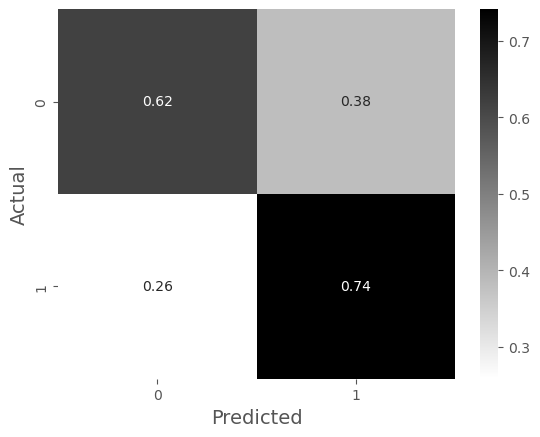

In [15]:
conf_matrix(y_test, y_pred_2)

In [16]:
print(classification_report(y_test, y_pred_2, labels=target_names))

              precision    recall  f1-score   support

           0       0.98      0.62      0.76    221444
           1       0.08      0.74      0.15     10509

    accuracy                           0.62    231953
   macro avg       0.53      0.68      0.45    231953
weighted avg       0.94      0.62      0.73    231953



# Метод опорных векторов

1. Провести классификацию с помощью метода опорных векторов по 2 признакам. Оценить качество полученной модели. При построении модели учесть сильный дисбаланс классов. 

In [17]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

In [18]:
np.random.seed(123)
rand_index = np.random.choice(X_train.index,10000)

In [19]:
X_train_learn = X_train.loc[rand_index]
y_train_learn = y_train.loc[rand_index]

In [20]:
y_train_learn.value_counts(normalize = True)

0    0.9553
1    0.0447
Name: popularity, dtype: float64

In [21]:
clf = svm.SVC(random_state=0, probability = True, kernel = 'linear', class_weight = 'balanced').fit(X_train_learn, y_train_learn)
#clf_pred=clf.predict(X_test)

<Figure size 800x600 with 0 Axes>

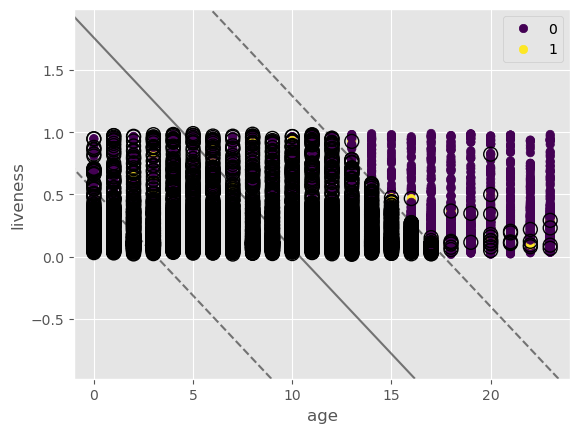

In [21]:
plt.figure(2, figsize=(8, 6))
fig, ax = plt.subplots()
scatter = ax.scatter(X_train_learn['age'], X_train_learn['liveness'], c=y_train_learn)
legend1 = ax.legend(*scatter.legend_elements(num=1), loc="upper right")
ax.add_artist(legend1)
plt.xlabel('age')
plt.ylabel('liveness')

# plot the decision function
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train_learn,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

ничего непонятно, но очень интересно

In [44]:
y_approx_1 = clf.predict(X_train_learn)
y_pred_1 = clf.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.98      0.59      0.74    221444
           1       0.08      0.76      0.15     10509

    accuracy                           0.60    231953
   macro avg       0.53      0.68      0.44    231953
weighted avg       0.94      0.60      0.71    231953



по precision результаты схожи с результатами логистической регрессии, метрика recall незначительно изменилась 

### Precision-recall

In [46]:
probabilities_svc = clf.predict_proba(X_train_learn)
probabilities_log = log_reg_2.predict_proba(X_train)

In [48]:
pr_0, rec_0, th_0 = precision_recall_curve(y_train_learn, probabilities_svc[:,1])
pr_1, rec_1, th_1 = precision_recall_curve(y_train, probabilities_log[:,1])

In [50]:
mod_0_auc = auc(rec_0[:-1], pr_0[:-1])
mod_1_auc = auc(rec_1[:-1], pr_1[:-1])

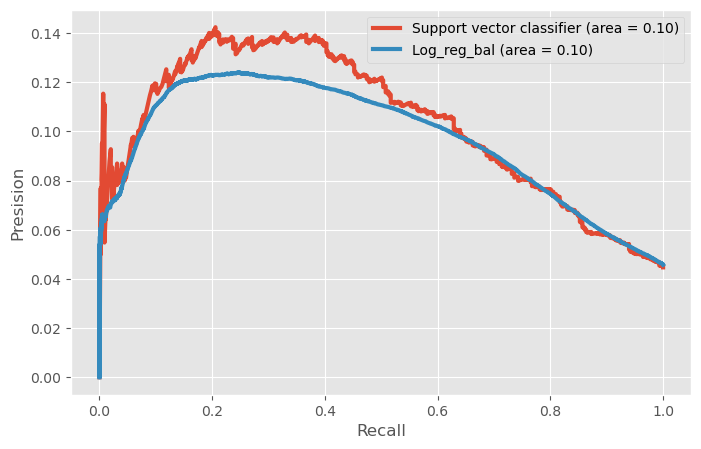

In [57]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rec_0[:-1], pr_0[:-1], linewidth = 3,label = 'Support vector classifier (area = %0.2f)' % mod_0_auc)
ax.plot(rec_1[:-1],pr_1[:-1], linewidth = 3,label = 'Log_reg_bal (area = %0.2f)' % mod_1_auc)
plt.legend(loc = "upper right")
plt.xlabel('Recall',fontsize = 12)
plt.ylabel('Presision',fontsize = 12)
plt.show()

Площадь под кривой одинакова, по данной метрике качество модели осталось на прежнем уровне

### ROC-AUC

In [54]:
fpr_0, tpr_0, th_0 = roc_curve(y_train_learn, probabilities_svc[:,1])
fpr_1, tpr_1, th_1 = roc_curve(y_train, probabilities_log[:,1])

In [55]:
mod_0_roc_auc = auc(fpr_0, tpr_0)
mod_1_roc_auc = auc(fpr_1, tpr_1)

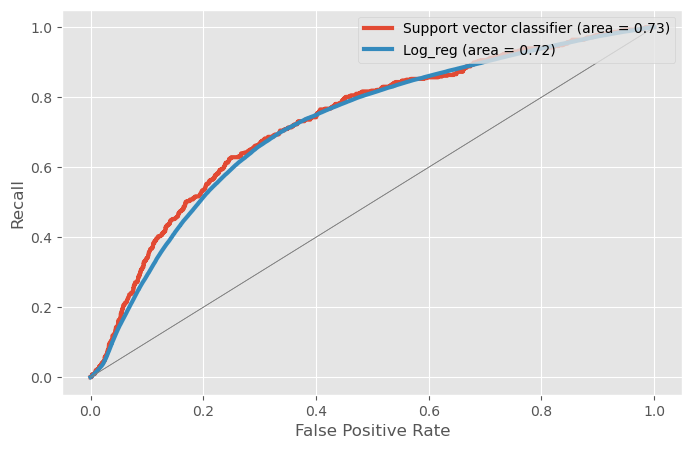

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(fpr_0, tpr_0, linewidth = 3,label = 'Support vector classifier (area = %0.2f)' % mod_0_roc_auc)
ax.plot(fpr_1, tpr_1, linewidth = 3,label = 'Log_reg (area = %0.2f)' % mod_1_roc_auc)
plt.plot([[0,0],[1,1]], linewidth=0.5, color='gray')
plt.legend(loc = "upper right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('Recall',fontsize = 12)
plt.show()

# Валидация параметров

2. Подобрать оптимальное значение параметра регуляризации и функции ядра, используя grid-search. Оценить качество полученной модели. Сравнить с лучшим результатом, достигнутым для логистической регрессии.

In [50]:
grid1 = {'C':np.linspace(0.1,10,5), 'kernel':['linear', 'rbf']} #линейная
grid2 = {'C': np.linspace(0.1,5,3), 'kernel':['poly'], 'degree': [2,3]} #полином со степенями 2,3
model_svm = svm.SVC(probability = True, class_weight = 'balanced')

In [51]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [52]:
from pactools.grid_search import GridSearchCVProgressBar

In [53]:
gs1 = GridSearchCVProgressBar(model_svm, grid1, cv = skf, scoring = 'roc_auc', verbose=3)

In [54]:
gs2 = GridSearchCVProgressBar(model_svm, grid2, cv = skf, scoring = 'roc_auc', verbose=3)

In [ ]:
#s1.fit(X_train_learn, y_train_learn)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ..............C=0.1, kernel=linear;, score=0.726 total time=   6.2s
[CV 2/3] END ..............C=0.1, kernel=linear;, score=0.730 total time=   6.4s
[CV 3/3] END ..............C=0.1, kernel=linear;, score=0.735 total time=   5.9s
[CV 1/3] END .................C=0.1, kernel=rbf;, score=0.719 total time=   9.6s
[CV 2/3] END .................C=0.1, kernel=rbf;, score=0.737 total time=  10.0s
[CV 3/3] END .................C=0.1, kernel=rbf;, score=0.732 total time=   9.7s


Питон не хочет валидировать модель по grid1, он стопается на новом C, при этом с grid2 все в порядке. Будем считать, что параметры, указанные в grid1 не будут лучше, чем в grid2

In [29]:
gs2.fit(X_train_learn, y_train_learn)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ......C=0.1, degree=2, kernel=poly;, score=0.724 total time=   6.1s
[CV 2/3] END ......C=0.1, degree=2, kernel=poly;, score=0.732 total time=   6.2s
[CV 3/3] END ......C=0.1, degree=2, kernel=poly;, score=0.731 total time=   6.0s
[CV 1/3] END ......C=0.1, degree=3, kernel=poly;, score=0.724 total time=   6.3s
[CV 2/3] END ......C=0.1, degree=3, kernel=poly;, score=0.732 total time=   6.3s
[CV 3/3] END ......C=0.1, degree=3, kernel=poly;, score=0.732 total time=   6.0s
[CV 1/3] END C=2.5500000000000003, degree=2, kernel=poly;, score=0.726 total time=   6.5s
[CV 2/3] END C=2.5500000000000003, degree=2, kernel=poly;, score=0.730 total time=   6.9s
[CV 3/3] END C=2.5500000000000003, degree=2, kernel=poly;, score=0.734 total time=   6.5s
[CV 1/3] END C=2.5500000000000003, degree=3, kernel=poly;, score=0.726 total time=   8.0s
[CV 2/3] END C=2.5500000000000003, degree=3, kernel=poly;, score=0.730 total time=   7.6s
[CV 

GridSearchCVProgressBar(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                        estimator=SVC(class_weight='balanced',
                                      probability=True),
                        param_grid={'C': array([0.1 , 2.55, 5.  ]),
                                    'degree': [2, 3], 'kernel': ['poly']},
                        scoring='roc_auc', verbose=3)

In [30]:
gs2.best_params_

{'C': 2.5500000000000003, 'degree': 2, 'kernel': 'poly'}

In [59]:
best_model = gs2.best_estimator_
best_model

SVC(C=2.5500000000000003, class_weight='balanced', degree=2, kernel='poly',
    probability=True)

In [60]:
y_approx = best_model.predict(X_train_learn)
y_pred = best_model.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.47      0.64    221444
           1       0.07      0.83      0.13     10509

    accuracy                           0.49    231953
   macro avg       0.53      0.65      0.38    231953
weighted avg       0.94      0.49      0.62    231953



В целом, модель оказалась хуже по метрикам precision и recall для 0 и 1 в сравнении с моделью логистической регрессии

In [62]:
probabilities_svc_g = best_model.predict_proba(X_train_learn)
pr_g, rec_g, th_g = precision_recall_curve(y_train_learn, probabilities_svc_g[:,1])
mod_g_auc = auc(rec_g[:-1], pr_g[:-1])

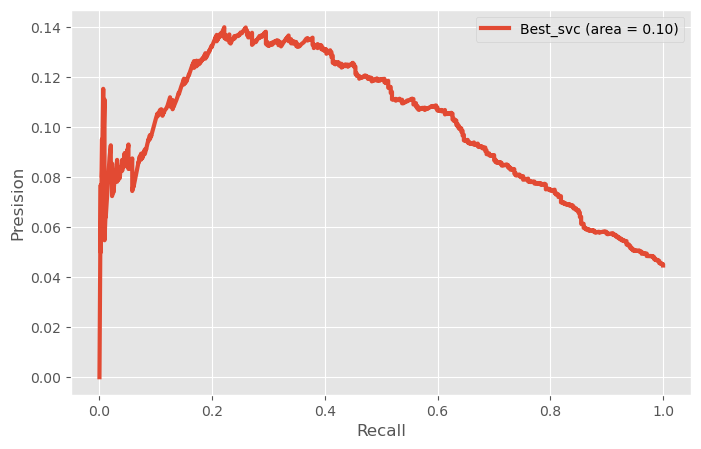

In [64]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rec_g[:-1], pr_g[:-1], linewidth = 3,label = 'Best_svc (area = %0.2f)' % mod_g_auc)
plt.legend(loc = "upper right")
plt.xlabel('Recall',fontsize = 12)
plt.ylabel('Presision',fontsize = 12)
plt.show()

In [65]:
fpr_g, tpr_g, th_g = roc_curve(y_train_learn, probabilities_svc_g[:,1])
mod_g_roc_auc = auc(fpr_g[:-1], tpr_g[:-1])

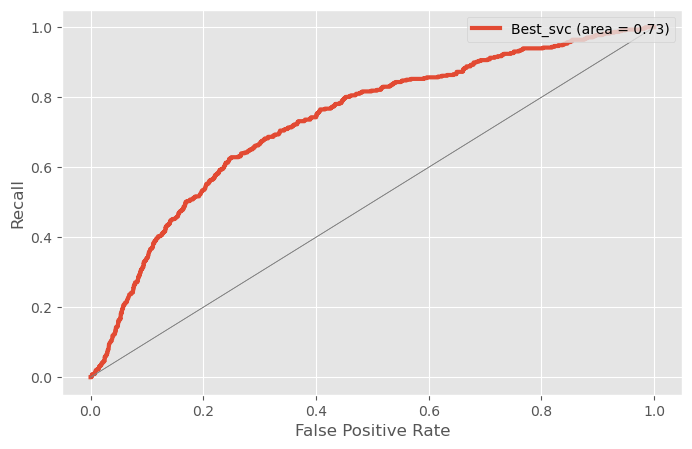

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(fpr_0, tpr_0, linewidth = 3,label = 'Best_svc (area = %0.2f)' % mod_0_roc_auc)
plt.plot([[0,0],[1,1]], linewidth=0.5, color='gray')
plt.legend(loc = "upper right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('Recall',fontsize = 12)
plt.show()

На метриках площади под кривой precision recall и roc-auc изменения параметров не отразились

# Улучшение модели

In [35]:
ds_new = ds[['popularity', 'age', 'liveness', 'tempo', 'danceability', 'mode']]

In [36]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    ds_new.drop('popularity', axis =1), 
    ds_new['popularity'], 
    test_size=0.2, 
    random_state=21)

In [37]:
np.random.seed(666)
new_rand_index = np.random.choice(new_X_train.index,10000)
new_X_train_learn = new_X_train.loc[new_rand_index]
new_y_train_learn = new_y_train.loc[new_rand_index]

повалидируем, увеличим возможные С

In [72]:
grid = {'C': [0.001, 0.1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3]} #полином со степенями 2,3
model_svm = svm.SVC(probability = True, class_weight = 'balanced')
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
gs = GridSearchCVProgressBar(model_svm, grid, cv = skf, scoring = 'roc_auc', verbose=3)

In [73]:
gs.fit(new_X_train_learn, new_y_train_learn)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END ....C=0.001, degree=2, kernel=poly;, score=0.521 total time=   9.3s
[CV 2/4] END ....C=0.001, degree=2, kernel=poly;, score=0.725 total time=   9.1s
[CV 3/4] END ....C=0.001, degree=2, kernel=poly;, score=0.583 total time=   9.3s
[CV 4/4] END ....C=0.001, degree=2, kernel=poly;, score=0.609 total time=   9.2s
[CV 1/4] END ....C=0.001, degree=3, kernel=poly;, score=0.518 total time=   9.3s
[CV 2/4] END ....C=0.001, degree=3, kernel=poly;, score=0.736 total time=   9.4s
[CV 3/4] END ....C=0.001, degree=3, kernel=poly;, score=0.580 total time=   9.3s
[CV 4/4] END ....C=0.001, degree=3, kernel=poly;, score=0.596 total time=   9.1s
[CV 1/4] END ......C=0.1, degree=2, kernel=poly;, score=0.748 total time=   8.3s
[CV 2/4] END ......C=0.1, degree=2, kernel=poly;, score=0.738 total time=   8.3s
[CV 3/4] END ......C=0.1, degree=2, kernel=poly;, score=0.730 total time=   8.2s
[CV 4/4] END ......C=0.1, degree=2, kernel=poly;

GridSearchCVProgressBar(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                        estimator=SVC(class_weight='balanced',
                                      probability=True),
                        param_grid={'C': [0.001, 0.1, 10, 100, 1000],
                                    'degree': [2, 3], 'kernel': ['poly']},
                        scoring='roc_auc', verbose=3)

In [74]:
gs.best_params_

{'C': 1000, 'degree': 2, 'kernel': 'poly'}

In [77]:
new_model = gs.best_estimator_
new_model

SVC(C=1000, class_weight='balanced', degree=2, kernel='poly', probability=True)

In [78]:
y_approx_new = new_model.predict(new_X_train_learn)
y_pred_new = new_model.predict(new_X_test)

In [79]:
print(classification_report(new_y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.98      0.63      0.77    221444
           1       0.09      0.74      0.16     10509

    accuracy                           0.64    231953
   macro avg       0.53      0.69      0.46    231953
weighted avg       0.94      0.64      0.74    231953



In [80]:
probabilities_svc_new = new_model.predict_proba(new_X_train_learn)
pr_new, rec_new, th_new = precision_recall_curve(new_y_train_learn, probabilities_svc_new[:,1])
mod_n_auc = auc(rec_new[:-1], pr_new[:-1])

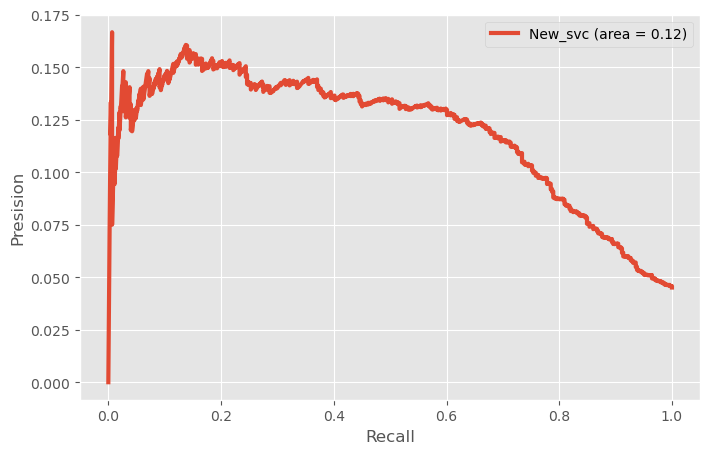

In [81]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rec_new[:-1], pr_new[:-1], linewidth = 3,label = 'New_svc (area = %0.2f)' % mod_n_auc)
plt.legend(loc = "upper right")
plt.xlabel('Recall',fontsize = 12)
plt.ylabel('Presision',fontsize = 12)
plt.show()

метрика площади под кривой precision-recall незначительно увеличилась 

In [82]:
fpr_new, tpr_new, th_new = roc_curve(new_y_train_learn, probabilities_svc_new[:,1])
mod_new_roc_auc = auc(fpr_new[:-1], tpr_new[:-1])

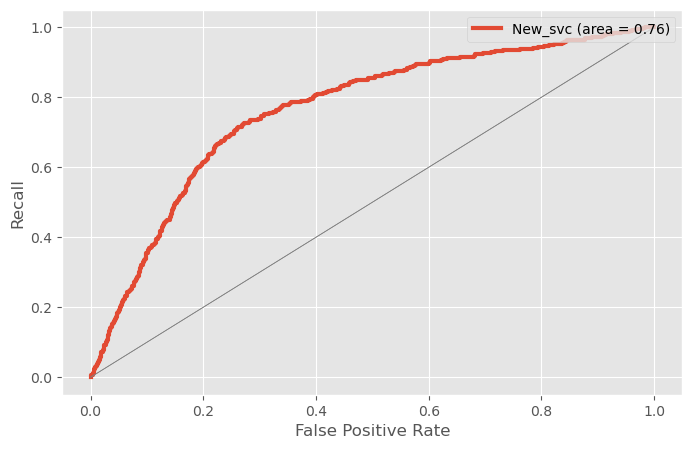

In [83]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(fpr_new, tpr_new, linewidth = 3,label = 'New_svc (area = %0.2f)' % mod_new_roc_auc)
plt.plot([[0,0],[1,1]], linewidth=0.5, color='gray')
plt.legend(loc = "upper right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('Recall',fontsize = 12)
plt.show()

метрика площади под кривой roc увеличилась на 0.04. Увеличение небольшое, но оно есть!

# Выводы

1) Модель неплоха по roc-auc, но дает плохие результаты по precision для 1 и по площади под кривой precision-recall.
2) Лучшей функциональной формой является полином (2 или 3 степени)
3) Немного улучшить показатели модели позволило увеличение параметра С до 1000 (ослабление регуляризации)
4) Для дальнейшего увеличения качества модели можно попытаться еще сильнее увеличить параметр С, а также включить доп. факторы в модель (которые будут сильнее оказывать влияние на popularity, например фиктивные переменные по топу жанров)